In [1]:
import plotly.plotly as py
import plotly.tools as tools
from collections import Counter
from googlemaps import googlemaps
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import string
import urllib2
import json
%matplotlib inline

# Load the data

In [2]:
df = pd.read_csv('loan.csv', dtype=object)

# Data Exploration

Change the var types for ploting

In [3]:
df.grade = pd.Categorical(df.grade)
df.loan_amnt = np.float64(df.loan_amnt)
df.annual_inc = np.float64(df.annual_inc)
df.int_rate = np.float64(df.int_rate)
df.total_rec_late_fee = np.float64(df.total_rec_late_fee)
df.dti = np.float64(df.dti)

### Interest Rate and Loan Grade

In [19]:
import plotly.graph_objs as go

x_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

y0 = df.int_rate[df.grade == 'A'].sample(1000)
y1 = df.int_rate[df.grade == 'B'].sample(1000)
y2 = df.int_rate[df.grade == 'C'].sample(1000)
y3 = df.int_rate[df.grade == 'D'].sample(1000)
y4 = df.int_rate[df.grade == 'E'].sample(1000)
y5 = df.int_rate[df.grade == 'F'].sample(1000)
y6 = df.int_rate[df.grade == 'G'].sample(1000)

y_data = [y0, y1, y2, y3, y4, y5, y6]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)',\
          'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)', 'rgba(255, 87, 50, 0.5)']

traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.1,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Interest Rate by Loan Grade',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=True
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

### Map from Zip Code

#### Function that takes a Zip code and returns the lat and lng of the center of the polygon (by the GoogleMaps API)

In [2]:
def GetLatLng(Zip):
    API_KEY = '<Your API Key>'
    url = urllib2.urlopen('https://maps.googleapis.com/maps/api/geocode/json?address=' + str(Zip) + '01' + '&key=' + str(API_KEY))
    json_url = json.loads(url.read())
    lat = json_url['results'][0]['geometry']['location']['lat']
    lon = json_url['results'][0]['geometry']['location']['lng']
    name = json_url['results'][0]['address_components'][1]['short_name']
    
    return [name, lat, lon]

Remove the XX from the Zip Codes

In [ ]:
zipcode = df.zip_code

zipcode_new = []
for code in zipcode:
    zipcode_new.append(code[:-2])

df.zip_code = zipcode_new

Most common Zip Codes in The Data

In [193]:
count = Counter(df.zip_code)
most_common = count.most_common(100)

Get the lat and lng of the 20 most common Zip Codes in the Data

In [194]:
zip_df = []
for i in range(len(most_common)):
    try:
        zip_df.append(GetLatLng(most_common[i][0]))
    except UnicodeEncodeError:
        zip_df.append(GetLatLng(most_common[i][0]))

In [195]:
zip_df = pd.DataFrame(zip_df, columns=['name', 'lat', 'lng'])

In [196]:
loans = []
for i in range(len(most_common)):
    loans.append(most_common[i][1])

zip_df['loans'] = loans

Remove Outliers

In [197]:
zip_df = zip_df[zip_df.lng < 0]

Plot the map with Plotly

In [ ]:
zip_df['text'] = zip_df['name'] + '<br>Loans ' + (zip_df['loans']).astype(str)
limits = [(0,5),(6,10),(11,16),(16,20),(21,50),(51,100)]
colors = ["rgb(242,240,247)","rgb(218,218,235)","rgb(188,189,220)","rgb(158,154,200)",'rgb(117,107,177)',"rgb(84,39,143)"][::-1]
cities = []

for i in range(len(limits)):
    lim = limits[i]
    df_sub = zip_df[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['lng'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['loans']/((i+4)**2),
            color = colors[i],
            line = dict(width=1, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(df_sub.loans.min(),df_sub.loans.max()))
    cities.append(city)

layout = dict(
        title = 'Number of Loans<br>(Click on the legend to toggle)',
        showlegend = True,
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa'),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=cities, layout=layout)
url = py.plot(fig, validate=False, filename='Loans')

In [199]:
tools.embed('https://plot.ly/~IdoZehori37/31/number-of-loans-click-on-the-legend-to-toggle/')

### Loans per 1000 people by state

read in population by state  
Data from: https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population

In [205]:
state_pop = pd.read_csv('US pop by state.csv')

Count states in the data

In [206]:
count_state = Counter(df.addr_state)

all_state = count_state.most_common()

In [207]:
all_state = pd.DataFrame(all_state, columns=['State', 'Loans'])

In [208]:
merged = all_state.merge(state_pop)

Create LoansFor1000P var

In [209]:
LoansFor1000P = []
for i in range(merged.shape[0]):
    LoansFor1000P.append((merged.Loans[i].astype(float))/(merged.Pop[i]/1000))

In [210]:
merged['LoansFor1000P'] = LoansFor1000P

Plot the map

In [269]:
colo = ['rgb(' + str(item[0]) + ',' + str(item[1]) + ',' + str(item[2]) + ')' for\
        item in sns.color_palette("RdBu_r", 6)]

In [270]:
for col in merged.columns:
    merged[col] = merged[col].astype(str)

scl = [[0.0, colo[0]], [0.2,colo[1]], [0.4, colo[2]], [0.6, colo[3]], [0.8, colo[4]], [1, colo[5]]]

merged['text'] = merged['State'] + '<br>' +\
    'Loans: ' + merged['Loans']+ '<br>' + 'Pop '+ merged['Pop']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = merged['State'],
        z = merged['LoansFor1000P'],
        locationmode = 'USA-states',
        text = merged['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "")
        ) ]

layout = dict(
        title = 'Loans per 1,000 people<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict(data=data, layout=layout )
py.iplot(fig, filename='Loans per 1,000 people')

### Client employment

In [14]:
states = df.addr_state.unique()

In [119]:
emp = pd.DataFrame(Counter(df.emp_title).most_common(15), columns=['profession', 'N'])

Unite 'Teacher' and 'teacher'

In [ ]:
emp.N[emp.profession == 'Teacher'] = emp.N[emp.profession == 'Teacher'] + 2925

In [126]:
emp = emp[(emp.profession != 'teacher') & (emp.profession.isnull() == False)]

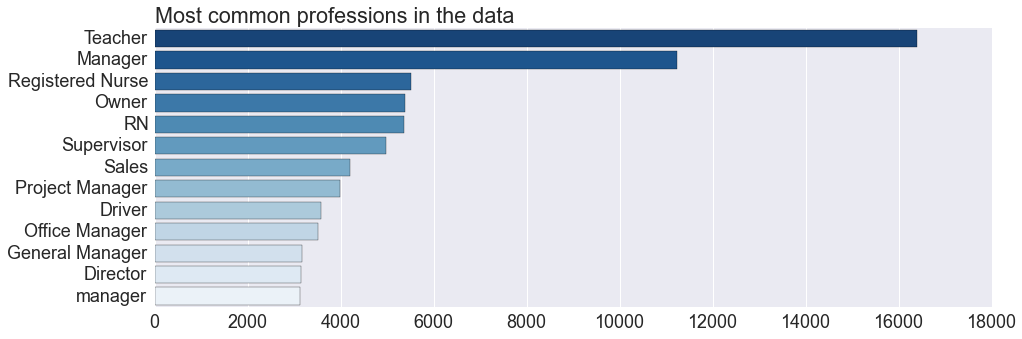

In [241]:
sns.set(font_scale=1.8)
ax = sns.barplot(data=emp, y = 'profession', x='N', orient='h', palette=sns.color_palette(palette='Blues', n_colors=len(emp))[::-1])
plt.title('Most common professions in the data', loc='left')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(15,5)

Get median teacher annual income by state

In [30]:
teacher_median = []
for state in states:
    teacher_median.append([state, df[((df.emp_title == 'Teacher') | (df.emp_title == 'Teacher')) &\
                                        (df.addr_state == state)][['annual_inc']].median()[0]])

In [34]:
teacher_median_df = pd.DataFrame(teacher_median, columns=['State', 'Income'])

In [40]:
teacher_median_df = teacher_median_df[teacher_median_df.Income.isnull() == False]

### Correct for PPP by state

In [164]:
state_ppp = pd.read_csv('ppp by state.csv')

In [175]:
state_ppp.columns = ['State', 'ppp', 'median_income']

In [178]:
teacher_median_df = teacher_median_df.merge(state_ppp, on='State')

In [184]:
income_ppp = []
for i in range(teacher_median_df.shape[0]):
    income_ppp.append(float(teacher_median_df.Income[i]) / (teacher_median_df.ppp[i]/100))   

In [185]:
teacher_median_df['Income_ppp'] = income_ppp

Plot teacher median income by state

In [271]:
for col in teacher_median_df.columns:
    teacher_median_df[col] = teacher_median_df[col].astype(str)

scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 111, 0)"]

teacher_median_df['text'] = teacher_median_df['State'] + '<br>' +\
    'Median Income (PPP corrected): ' + teacher_median_df['Income_ppp']+ '<br>' +\
    'Median Income (Nominal): ' + teacher_median_df['Income'] + '<br>' +\
    'Price Index: ' + teacher_median_df['ppp']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = teacher_median_df['State'],
        z = teacher_median_df['Income_ppp'],
        locationmode = 'USA-states',
        text = teacher_median_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "")
        ) ]

layout = dict(
        title = 'Median teacher income (PPP corrected) by State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict(data=data, layout=layout )
url = py.plot(fig, validate=False, filename='Loans')
py.iplot(fig, filename='Median teacher income by State')

### Analisis of the client loan description var (desc) in NL

Word tokenizing with NLTK

In [152]:
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS

In [153]:
desc_words = []
desc_original = df.desc.astype(str)
for i in range(len(desc_original)):
    try:
        desc_words.append(word_tokenize(desc_original[i][31:len(desc_original[i])-4:]))
    except UnicodeDecodeError:
        continue

Remove all the StopWords

In [154]:
to_add = ['I', '<br>', '.', ',', '?', '!', '<', '>', '(', ')', '%', '*', '@', '&', 'im', 'br', '...', 'Borrower' ,'added']
for i in range(len(to_add)):
    STOPWORDS.add(to_add[i])

In [155]:
for i in range(len(desc_words)):
    for word in desc_words[i]:
        if word in STOPWORDS:
            desc_words[i].remove(word)

Create long string containing all the words

In [156]:
all_words = ''
for i in range(len(desc_words)):
    for word in desc_words[i]:
        all_words += ' ' + word

Word cloud

In [157]:
from scipy.misc import imread
from wordcloud import WordCloud
from PIL import Image
from os import path

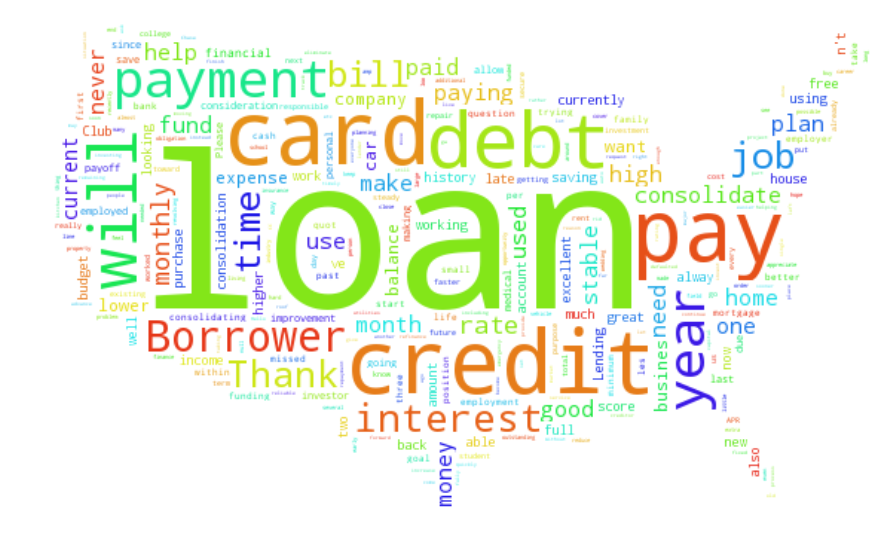

In [159]:
dollar_mask = imread(path.join("dollar2.jpg"))

wcloud = WordCloud(font_path=None, width=2000, height=300, margin=4, ranks_only=None,
                   prefer_horizontal=0.7, mask=dollar_mask, scale=1, max_words=2000, min_font_size=3,
                   stopwords=STOPWORDS, random_state=None, background_color='white', max_font_size=None,
                   font_step=1, mode='RGB', relative_scaling=0).generate(all_words[:1000000])

plt.imshow(wcloud)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.axis("off")
plt.show()

### Text analisis of the Loan title

In [ ]:
title_tok = []
for title in df.title:
    title_tok.append(word_tokenize(title))

Remove StopWords

In [229]:
for i in range(len(title_tok)):
    for word in title_tok[i]:
        if word in STOPWORDS:
            title_tok[i].remove(word)

In [231]:
all_words1 = ''
for i in range(len(title_tok)):
    for word in title_tok[i]:
        all_words1 += ' ' + word

Add Stop Words

In [236]:
to_add = ['loan', 'debt', 'consolidation', 'credit', 'card']
for i in range(len(to_add)):
    STOPWORDS.add(to_add[i])

Word Cloud

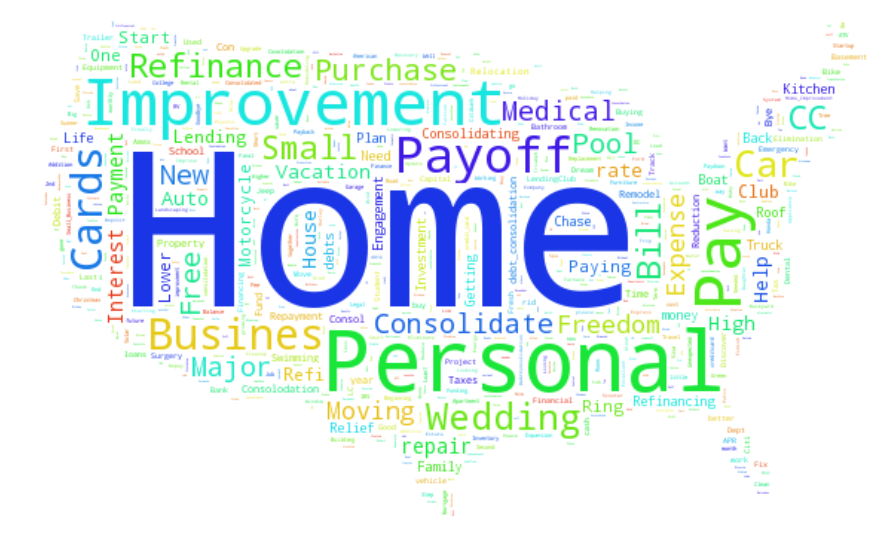

In [241]:
dollar_mask = imread(path.join("dollar2.jpg"))

wcloud = WordCloud(font_path=None, width=2000, height=300, margin=4, ranks_only=None,
                   prefer_horizontal=0.7, mask=dollar_mask, scale=1, max_words=2000, min_font_size=2,
                   stopwords=STOPWORDS, random_state=None, background_color='white', max_font_size=None,
                   font_step=1, mode='RGB', relative_scaling=0).generate(all_words1[:1000000])

plt.imshow(wcloud)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.axis("off")
plt.show()